# Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
#export
from exp.nb_07a import *

<IPython.core.display.Javascript object>

# Introduction

- Images 32 x 32 have very different characteristics than large images. Once you get below 96 x 96 they behave differently. This means what works well; for example on CIFAR 10, most likely will not work well on Imagenet. 128 x 128 pixel images do generalize well to bigger images, and conclusions made on such images hold well to large images and much faster to train.

These are subsets of Imagenet images with different sizes/characteristics:
- Imagenette: A subset of 10 easily classified classes from Imagenet.
- Imagewoof: A subset of 10 classes from Imagenet that aren’t easy to classify (all dog breeds).
- Imagewang: Imagenette and Imagewoof combined with some twists to make it into a tricky semi-supervised unbalanced classification problem.

Each of the datasets is available in 3 sizes:
- Full size.
- Shortest length resized to 160px (aspect ratio maintained).
- Shortest length resized to 320px (aspect ratio maintained).

A big part of a getting good at using deep learning in your domain is knowing how to create small, workable, useful datasets…
Try to come up with a toy problem or two that will give you insight into your full problem.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=600)

# Data block API foundations

In [3]:
#export
from fastai.data.external import download_url, URLs, untar_data

<IPython.core.display.Javascript object>

In [4]:
URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'

<IPython.core.display.Javascript object>

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

In [5]:
path = untar_data(URLs.IMAGENETTE_160)
path

Path('/Users/imad/.fastai/data/imagenette2-160')

<IPython.core.display.Javascript object>

To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [6]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

<IPython.core.display.Javascript object>

In [7]:
path.ls()

[Path('/Users/imad/.fastai/data/imagenette2-160/train'),
 Path('/Users/imad/.fastai/data/imagenette2-160/val')]

<IPython.core.display.Javascript object>

In [8]:
(path/'val').ls()[:2]

[Path('/Users/imad/.fastai/data/imagenette2-160/val/n03394916'),
 Path('/Users/imad/.fastai/data/imagenette2-160/val/n03417042')]

<IPython.core.display.Javascript object>

Let's have a look inside a class folder (the first class is tench):

In [9]:
path_tench = path/'val'/'n01440764'

<IPython.core.display.Javascript object>

In [10]:
img_fn = path_tench.ls()[0]
img_fn

Path('/Users/imad/.fastai/data/imagenette2-160/val/n01440764/n01440764_32420.JPEG')

<IPython.core.display.Javascript object>

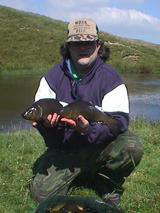

<IPython.core.display.Javascript object>

In [11]:
img = PIL.Image.open(img_fn)
img

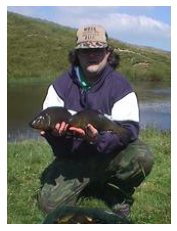

<IPython.core.display.Javascript object>

In [12]:
plt.imshow(img)
plt.axis('off');

In [13]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

<IPython.core.display.Javascript object>

In [14]:
import numpy
imga = numpy.array(img)
imga.shape

(213, 160, 3)

<IPython.core.display.Javascript object>

In [15]:
imga[:10,:10,0]

array([[168, 167, 165, 165, 165, 169, 176, 180, 173, 174],
       [168, 168, 172, 176, 178, 178, 173, 170, 169, 172],
       [177, 172, 167, 167, 173, 176, 178, 176, 177, 177],
       [179, 176, 172, 169, 169, 173, 177, 181, 177, 176],
       [153, 165, 178, 182, 178, 175, 174, 176, 178, 176],
       [115, 130, 147, 154, 155, 160, 172, 184, 187, 187],
       [ 96, 102, 108, 110, 113, 126, 148, 166, 166, 169],
       [103, 105, 105, 100,  96,  98, 106, 114, 115, 126],
       [111,  99,  87,  84,  91, 101, 108, 109, 105, 105],
       [100,  95,  90,  91,  97, 101,  99,  96, 103, 105]], dtype=uint8)

<IPython.core.display.Javascript object>

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database). __MIME types__ are the media types which are two-part identifier for file formats and format contents transmitted on the Internet. 

In [16]:
list(mimetypes.types_map.items())[:5]

[('.js', 'application/javascript'),
 ('.mjs', 'application/javascript'),
 ('.json', 'application/json'),
 ('.webmanifest', 'application/manifest+json'),
 ('.doc', 'application/msword')]

<IPython.core.display.Javascript object>

In [17]:
list(mimetypes.types_map.keys())[:5]

['.js', '.mjs', '.json', '.webmanifest', '.doc']

<IPython.core.display.Javascript object>

In [18]:
#export
image_extensions = set(k for k, v in mimetypes.types_map.items()
                       if v.startswith('image/'))

<IPython.core.display.Javascript object>

In [19]:
' '.join(image_extensions)

'.mmr .pcx .svgz .wbmp .uvvi .uvi .fpx .webp .ief .mac .ico .fh .pntg .fst .rgb .pnt .dxf .btif .3ds .sgi .xif .jpg .xwd .cmx .npx .fh7 .jpe .pic .psd .pnm .g3 .ras .uvvg .xpm .ktx .tga .pict .fhc .jp2 .mdi .fh4 .tiff .sid .tif .qtif .png .jpeg .djv .rlc .pct .uvg .wdp .bmp .svg .dwg .pgm .pbm .fh5 .qti .djvu .cgm .fbs .gif .xbm .ppm'

<IPython.core.display.Javascript object>

`set` is faster than list when checking if the an element is in the collection.

In [20]:
#export
def setify(o):
    return o if isinstance(o, set) else set(listify(o))

<IPython.core.display.Javascript object>

In [21]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa', 1]), {'aa', 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

<IPython.core.display.Javascript object>

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

In [22]:
#export
def _get_files(p, fs, extensions=None):
    """Get filenames in `path` that have extension `extensions`."""
    p = Path(p)
    res = [
        p / f for f in fs if not f.startswith('.') and (
            (not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)
    ]
    return res

<IPython.core.display.Javascript object>

In [23]:
# Returns all the file names in a path directory
t = [o.name for o in os.scandir(path_tench)]

# Get filenames of images only
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[Path('/Users/imad/.fastai/data/imagenette2-160/n01440764_32420.JPEG'),
 Path('/Users/imad/.fastai/data/imagenette2-160/n01440764_4562.JPEG'),
 Path('/Users/imad/.fastai/data/imagenette2-160/n01440764_910.JPEG')]

<IPython.core.display.Javascript object>

In [24]:
path_tench

Path('/Users/imad/.fastai/data/imagenette2-160/val/n01440764')

<IPython.core.display.Javascript object>

In [25]:
os.scandir??

<IPython.core.display.Javascript object>

Signature: os.scandir(path=None)
Docstring:
Return an iterator of DirEntry objects for given path.

path can be specified as either str, bytes, or a path-like object.  If path
is bytes, the names of yielded DirEntry objects will also be bytes; in
all other circumstances they will be str.

If path is None, uses the path='.'.
Type:      builtin_function_or_method


In [26]:
[attr for attr in dir(list(os.scandir(path_tench))[0]) if not attr.startswith("__")]

['inode', 'is_dir', 'is_file', 'is_symlink', 'name', 'path', 'stat']

<IPython.core.display.Javascript object>

In [27]:
list(os.scandir('.'))[:5]

[<DirEntry '01_Matrix-Multiplication.ipynb'>,
 <DirEntry '11_train_imagenette.ipynb'>,
 <DirEntry 'transforms-dali.ipynb'>,
 <DirEntry '04_Callbacks-Imad.ipynb'>,
 <DirEntry 'audio.ipynb'>]

<IPython.core.display.Javascript object>

In [28]:
list(Path('../').rglob("*.png"))

[Path('../resources/kaiming_init_derivation.png'),
 Path('../resources/xavier_init_derivation.png'),
 Path('../notebooks/images/seq2seq.png'),
 Path('../notebooks/images/attention.png'),
 Path('../notebooks/images/Transformer.png'),
 Path('../notebooks/images/overfit.png'),
 Path('../notebooks/images/retinanet.png'),
 Path('../notebooks/images/half_representation.png'),
 Path('../notebooks/images/half.png'),
 Path('../notebooks/images/beta.png'),
 Path('../notebooks/images/norms.png')]

<IPython.core.display.Javascript object>

In [29]:
%timeit [list(path_tench.parent.parent.rglob(f"*{ext.upper()}")) for ext in image_extensions]

2.64 s ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>

In [30]:
os.walk?

<IPython.core.display.Javascript object>

Signature: os.walk(top, topdown=True, onerror=None, followlinks=False)
Docstring:
Directory tree generator.

For each directory in the directory tree rooted at top (including top
itself, but excluding '.' and '..'), yields a 3-tuple

    dirpath, dirnames, filenames

dirpath is a string, the path to the directory.  dirnames is a list of
the names of the subdirectories in dirpath (excluding '.' and '..').
filenames is a list of the names of the non-directory files in dirpath.
Note that the names in the lists are just names, with no path components.
To get a full path (which begins with top) to a file or directory in
dirpath, do os.path.join(dirpath, name).

If optional arg 'topdown' is true or not specified, the triple for a
directory is generated before the triples for any of its subdirectories
(directories are generated top down).  If topdown is false, the triple
for a directory is generated after the triples for all of its
subdirectories (directories are generated bottom up).

When t

In [31]:
list(os.walk(Path("/Users/imad/Desktop/")))

[('/Users/imad/Desktop',
  ['mama'],
  ['.DS_Store',
   '.swp',
   'TxDMV - Vehicle Registration Renewal.pdf',
   'computer-architecture-quantitative-approach (dragged) 4.pdf',
   'computer-architecture-quantitative-approach (dragged) 3.pdf',
   'computer-architecture-quantitative-approach (dragged) 2.pdf']),
 ('/Users/imad/Desktop/mama',
  [],
  ['image0.jpeg',
   'image1.jpeg',
   'certificate.JPG',
   'narrative.jpg',
   'image2.jpeg'])]

<IPython.core.display.Javascript object>

In [32]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

<IPython.core.display.Javascript object>

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [33]:
get_files(path, image_extensions, recurse=True)[:3]

[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),
 Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'),
 Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG')]

<IPython.core.display.Javascript object>

In [34]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

<IPython.core.display.Javascript object>

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [35]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

69.4 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

# Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the `ListContainer` class from notebook 06 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it. Note that the list would only contain file names and not the actual data, i.e. we don't store data into memory unless we need it.

An item in an ItemList would be any data point such as image, text, etc. When we ask for an item, a list of transforms are composed and applied to that item before returning it.

>> 
__Note__: `compose` function: takes a list of functions and combines them into a pipeline that chains the outputs of the first function to input of the second and so on. NN can be seen as a composition of layers.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [36]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): 
        x = f(x, **kwargs)
    return x


class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path = Path(path)
        self.tfms = tfms

    def __repr__(self): 
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: 
            cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): 
        return i
    
    def _get(self, i): 
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): 
            return [self._get(o) for o in res]
        return self._get(res)

    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: 
            extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): 
        return PIL.Image.open(fn)

<IPython.core.display.Javascript object>

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [37]:
#export
class Transform(): 
    _order=0


# We can use either function or class to convert to RGB
class MakeRGB(Transform):
    def __call__(self, item): 
        # if the image is already rgb, then PIL does not do anything
        return item.convert('RGB')

    
def make_rgb(item): 
    return item.convert('RGB')

<IPython.core.display.Javascript object>

In [38]:
il = ImageList.from_files(path, tfms=make_rgb)
il

ImageList (13394 items)
[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/imad/.fastai/data/imagenette2-160

<IPython.core.display.Javascript object>

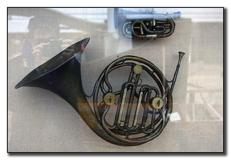

<IPython.core.display.Javascript object>

In [39]:
img = il[0]; img

We can also index with a range or a list of integers:

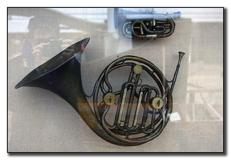

<IPython.core.display.Javascript object>

In [40]:
il.get(all_fns[0])

In [41]:
il[:1]

[<PIL.Image.Image image mode=RGB size=231x160 at 0x7F864B5E0B80>]

<IPython.core.display.Javascript object>

### Split validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [42]:
fn = il.items[0]; fn

Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG')

<IPython.core.display.Javascript object>

Since our filenames are `path` object, we can find the directory of the file with `.parent`. We need to go back two folders before since the last folders are the class names.

In [43]:
fn.parent.parent.name

'train'

<IPython.core.display.Javascript object>

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2175)

In [44]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    if gp == valid_name:
        return True
    elif gp == train_name:
        return False
    return
#     return True if gp == valid_name else False if gp==train_name else None


def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    val = [o for o, m in zip(items, mask) if m]
    train = [o for o, m in zip(items, mask) if m == False]
    return train, val

<IPython.core.display.Javascript object>

In [45]:
splitter = partial(grandparent_splitter, valid_name='val')

<IPython.core.display.Javascript object>

In [46]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 39.2 ms, sys: 2.01 ms, total: 41.2 ms
Wall time: 40.7 ms


<IPython.core.display.Javascript object>

In [47]:
len(train), len(valid)

(9469, 3925)

<IPython.core.display.Javascript object>

In [48]:
len(get_files(path / 'train', image_extensions, recurse=True))

9469

<IPython.core.display.Javascript object>

In [49]:
len(get_files(path / 'val', image_extensions, recurse=True))

3925

<IPython.core.display.Javascript object>

Now that we can split our data, let's create the class that will contain it. It just needs two `ItemList` to be initialized, and we create a shortcut to all the unknown attributes by trying to grab them in the `train` `ItemList`. 

In [50]:
#export
class SplitData:
    def __init__(self, train, valid): 
        self.train = train
        self.valid = valid
        
    def __getattr__(self,k): 
        return getattr(self.train, k)
    
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self, data): 
        self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)
    
    def __repr__(self): 
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

<IPython.core.display.Javascript object>

In [51]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (9469 items)
[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/imad/.fastai/data/imagenette2-160
Valid: ImageList (3925 items)
[

<IPython.core.display.Javascript object>

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=2368)

In [52]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: 
        res.sort()
    return res

<IPython.core.display.Javascript object>

First, let's define the processor. We also define a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding `obj` will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [53]:
#export
class Processor: 
    def process(self, items): 
        return items

class CategoryProcessor(Processor):
    def __init__(self): 
        self.vocab = None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.process(o) for o in items]
    
    def process(self, item):  
        return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None, "Vocab is not defined"
        return [self._deprocess(idx) for idx in idxs]
    
    def _deprocess(self, idx): 
        return self.vocab[idx]

<IPython.core.display.Javascript object>

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [54]:
#export
def parent_labeler(fn): 
    return fn.parent.name


def _label_by_func(ds, f, cls=ItemList): 
    return cls([f(o) for o in ds.items], path=ds.path)


#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData:
    
    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x = self.process(x, proc_x)
        self.y = self.process(y, proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y
    
    def process(self, il, proc): 
        return il.new(compose(il.items, proc))
        
    def __repr__(self): 
        return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    
    def __getitem__(self,idx): 
        return self.x[idx], self.y[idx]
    
    def __len__(self): 
        return len(self.x)
    
    def x_obj(self, idx): 
        return self.obj(self.x, idx, self.proc_x)
    
    def y_obj(self, idx): 
        return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc._deprocess(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

<IPython.core.display.Javascript object>

In [55]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

<IPython.core.display.Javascript object>

In [56]:
assert ll.train.proc_y is ll.valid.proc_y

<IPython.core.display.Javascript object>

In [57]:
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /Users/imad/.fastai/data/imagenette2-160

<IPython.core.display.Javascript object>

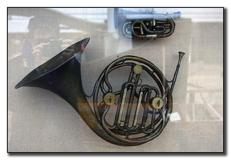

<IPython.core.display.Javascript object>

In [59]:
ll.train.x[0]

In [60]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03394916', ['n03394916', 'n03394916'])

<IPython.core.display.Javascript object>

In [61]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /Users/imad/.fastai/data/imagenette2-160
y: ItemList (946

<IPython.core.display.Javascript object>

### Transform to tensor

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=3044)

In [62]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=231x160 at 0x7F864B621550>, 0)

<IPython.core.display.Javascript object>

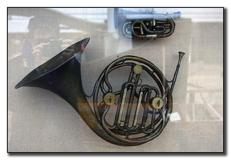

<IPython.core.display.Javascript object>

In [63]:
ll.train[0][0]

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

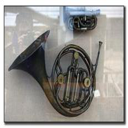

<IPython.core.display.Javascript object>

In [64]:
ll.train[0][0].resize((128,128))

The first transform resizes to a given size, then we convert the image to a byte tensor before converting it to float and dividing by 255. We will investigate data augmentation transforms at length in notebook 10.

In [65]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size, int): 
            size = (size, size)
        self.size = size
        
    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)

    
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item):
    return item.float().div_(255.)
to_float_tensor._order=20

<IPython.core.display.Javascript object>

In [66]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

<IPython.core.display.Javascript object>

Here is a little convenience function to show an image from the corresponding tensor.

In [67]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

<IPython.core.display.Javascript object>

In [68]:
x, y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

<IPython.core.display.Javascript object>

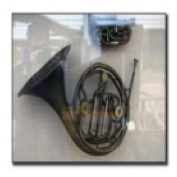

<IPython.core.display.Javascript object>

In [69]:
show_image(x)

# Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

In [70]:
bs=64

<IPython.core.display.Javascript object>

In [71]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

<IPython.core.display.Javascript object>

In [72]:
x.shape

torch.Size([3, 128, 128])

<IPython.core.display.Javascript object>

We can still see the images in a batch and get the corresponding classes.

'n03394916'

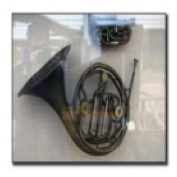

<IPython.core.display.Javascript object>

In [74]:
show_image(x)
ll.train.proc_y.vocab[y]

In [75]:
y

0

<IPython.core.display.Javascript object>

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [76]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

<IPython.core.display.Javascript object>

Then we define a function that goes directly from the `SplitData` to a `DataBunch`.

In [77]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

<IPython.core.display.Javascript object>

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [78]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

<IPython.core.display.Javascript object>

### Model

In [97]:
cbfs = [partial(AvgStatsCallback,accuracy),]
#         CudaCallback]

<IPython.core.display.Javascript object>

We will normalize with the statistics from a batch.

In [98]:
m,s = x[None].mean((0,2,3)),x[None].std((0,2,3))
m,s

(tensor([0.5861, 0.5792, 0.5655]), tensor([0.2536, 0.2538, 0.2577]))

<IPython.core.display.Javascript object>

In [99]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)

<IPython.core.display.Javascript object>

In [100]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

<IPython.core.display.Javascript object>

In [101]:
nfs = [64,64,128,256]

<IPython.core.display.Javascript object>

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

In [102]:
#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_learner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

<IPython.core.display.Javascript object>

In [103]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

<IPython.core.display.Javascript object>

In [104]:
learner = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

<IPython.core.display.Javascript object>

Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [105]:
#export
def model_summary(learner, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, learner)
    device = next(learner.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learner.model, is_lin_layer) if find_all else learner.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learner.model(xb)

<IPython.core.display.Javascript object>

In [114]:
from torch.optim import SGD

<IPython.core.display.Javascript object>

In [109]:
# model_summary(learner, data)

<IPython.core.display.Javascript object>

And we can train the model:

In [220]:
# %time run.fit(5, learn)

<IPython.core.display.Javascript object>

The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

# Export

In [267]:
!python ../src/notebook2script.py 08_Data_Block-Imad.ipynb

Converted 08_Data_Block-Imad.ipynb to exp/nb_08.py


<IPython.core.display.Javascript object>